In [1]:
from whoosh.index import create_in
from whoosh.fields import *
from whoosh.analysis import *
from whoosh.qparser import *
from whoosh import scoring
from whoosh import *
from whoosh.writing import AsyncWriter
import csv
import time
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from Eval_metrics import * #my script .py with the implementation of the eval metrics
import random

In [11]:
''' Define a function to convert the html file into csv'''
def converter():
    #path to the html files for the Cranfield_DATASET
    path_Cranfield = os.getcwd()+ "\part_1\part_1_1\Cranfield_DATASET\DOCUMENTS\_" 
    #initialization of the dataframe for the crainfield csv   
    cranfield_df=pd.DataFrame(columns=['ID','title','body']) 
    # for each doc in the folder Cranfield_DATASET
    for i in range(1,1401): 
        #define the file name
        filename1=path_Cranfield+'_'*5+str(i)+'.html' 
        #open the file in reading mode
        with open(filename1) as f:
            content = f.read() 
        #use a html parser to pick the content of the file 
        soup = BeautifulSoup(content, 'html.parser')
        # save the title 
        title=soup.title.string 
        # save the body
        body=soup.body.string 
        #store into the dataframe the content. Each row of the document df is a .html file
        cranfield_df=cranfield_df.append({'ID':i,'title':title,'body':body},ignore_index=True) 
    return cranfield_df

# save the doc from Cranfield dataset into csv file format
doc_Cran_converted = converter()
doc_Cran_converted.to_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\doc_to_index.csv")

In [2]:
'''DEFINE THE FIRST PART OF THE SOFTWARE FOR THE SE''' 
def sw_1(analyzer,filename):
    # creating schema with fields id, title and content
    schema = Schema(id=ID(stored=True),title=TEXT(stored=False, analyzer=analyzer),\
                content=TEXT(stored=False, analyzer=analyzer))
    directory_containing_the_index = os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET" 
    # create an empty-index according to the just defined schema in the directory where csv file is
    ix = create_in(directory_containing_the_index, schema) 
    # open the index file
    ix = index.open_dir(directory_containing_the_index) #open the index file 
    writer =  AsyncWriter(ix) #define a writer object to add content to the fields
    # fill the index:
    ALL_DOCUMENTS_file_name = filename #path of the file 
    # open the file
    in_file = open(ALL_DOCUMENTS_file_name, "r", encoding='latin1')
    # read it as csv
    csv_reader = csv.reader(in_file, delimiter=',')  
    # to skip the header: first line contains the name of each field.
    csv_reader.__next__()
    # for each row in the 'doc_to_index' file 
    for record in csv_reader: 
        id0 = record[1] # extract the id doc
        title = record[2] # extract the title
        content = record[3] # extract the body
        # add this new doc into the inverted index according to the schema
        writer.add_document(id=id0, content=title+' '+content)
    # commit all the operations on the file
    writer.commit()
    # close the file
    in_file.close()

In [3]:
''' DEFINE THE QUERY ENGINE (THE SECOND PART OF THE SOFTWARE FOR THE SE)'''
'''
Method that given the input query and given the specific SE configuration returns the results of the search
input:
    analyzer - selected text analyzer from the whoosh library
    score_fun - selected scoring function from the whoosh library
    input_query - query that's being used for evaluation
    max_number_of_results - maximal number of results that should be retrieved which are equal to the number of relevant documents related to that specific query (which we need for calculating R-precision)
output: answer - dataframe with results of the given SE given the query; columns of dataframe: ["Rank" , "Doc_ID" , "Score"]
''' 
def sw_2(score_fun,input_query,max_number_of_results):
    directory_containing_the_index = os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET" 
    # thanks to the ix we can retreive doc of interest for the given SE configurations
    ix = index.open_dir(directory_containing_the_index) 
    # define a QueryParser for parsing the input_query
    qp = QueryParser("content", ix.schema)
    # apply it on the given query
    parsed_query = qp.parse(input_query) #  qp.parse(q)
    # create a Searcher for the Index with the given scoring function 
    searcher = ix.searcher(weighting=score_fun) 
    # store results of the query and limiting max number of results
    results = searcher.search(parsed_query,limit=max_number_of_results) 
    # define a dataframe to store the results 
    result=pd.DataFrame() 
    row=pd.DataFrame()
    for hit in results:
        row=pd.DataFrame([str(hit.rank),int(hit['id']),str(hit.score)]).T
        result=result.append(row)
    result.columns=["Rank","Doc_ID","Score"] 
    # the column 'score' contains the values of the scoring function, that we use for having in a quantitative way the relevance of a doc for a particulare query
    searcher.close()
    return result

In [4]:
'''
Method that given the specific SE configuration(analyzer,score_fun)
executes and returns the results for ALL the queries 
input:
    analyzer - selected text analyzer from the whoosh library
    score_fun - selected scoring function from the whoosh library
output: result - dataframe with the results of the given SE for ALL the queries; columns of df: ["Rank" , "Doc_ID" , "Score"]
''' 
def executor(analyzer,score_fun):
    result=pd.DataFrame() # dataframe with the results of the given SE for ALL the queries; 
    tmp=pd.DataFrame() #tmp dataframe 
    # open the file with all the queries
    Queries_file=os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Queries.tsv"
    Queries=pd.read_csv(Queries_file,sep='\t')
    # open the file of the GT
    gt=pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Ground_Truth.tsv", sep='\t') 
    #define a list with the unique query ids

    Q=list(gt['Query_id'].unique()) 
    dq={} #key=Query_id, value=number of relevant documents related to that query_id
    for i in Q: # for each query_id
        dq[i]=len(list(gt[gt['Query_id']==i]['Relevant_Doc_id']))

    file_toindex=os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\doc_to_index.csv"
    # invoke the function to create the schema and to store the index file based on the retrieved 'doc_to_index.csv' file  
    sw_1(analyzer,file_toindex)
    # for each index in the query set
    for i in Q:
        # store the number of relevant documents related to the specific input query
        max_number_of_results_1q=dq[i] 
        if max_number_of_results_1q==0:
            max_number_of_results_1q=1
        # invoke the function that,given the input query and given the specific SE configuration,
        # returns the results of the search and store it into a tmp dataframe
        tmp=sw_2(score_fun,list(Queries[Queries['Query_ID']==i]['Query'])[0],max_number_of_results_1q)
        tmp['Query_id']=i
        result=result.append(tmp) #then for each query add it to the result dataframe 
    return result

In [5]:
# Score based on position (by Whoosh documentation)
def pos_score_fn(searcher, fieldname, text, matcher):
    poses = matcher.value_as("positions")
    return 1.0 / (poses[0] + 1)

In [6]:
def search_engine():
    # open the ground truth
    gt=pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Ground_Truth.tsv", sep='\t')
    list_mrr=[] # to store the MRR values for each SE configuration 
    # define the scoring functions
    score_functions = [scoring.FunctionWeighting(pos_score_fn),scoring.PL2(),scoring.BM25F(B=0.75, content_B=1.0, K1=1.5)]
    # define the text analyzers
    analyzers = [StemmingAnalyzer(),RegexAnalyzer(),FancyAnalyzer(),LanguageAnalyzer('en')]
    #combinations for every chosen analyzer with every chosen scoring function
    num_analyzers = len(analyzers)
    num_score_fun = len(score_functions)
    i=1
    sel_ana=['StemmingAnalyzer()','RegexAnalyzer()','FancyAnalyzer()','LanguageAnalyzer()']
    scor_func=[' FunctionWeighting',' PL2',' BM25F']
    for x in range(num_analyzers):
        for y in range(num_score_fun):
            print(sel_ana[x]+scor_func[y])
            # execute queries with the chosen configuration
            se=executor(analyzers[x],score_functions[y]) 
            #save results of the search engine
            se.to_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET"+str(i)+".csv",index=False) 
            #compute the MRR 
            list_mrr.append((sel_ana[x]+scor_func[y],MRR(se,gt))) 
            i+=1
    # save into a table with MRR evaluation for every search engine configuration 
    mrrs=pd.DataFrame(list_mrr)
    mrrs.to_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\mrr.csv", index=False) #store MRR table

In [7]:
# exec the search engine with the different configurations for the Cranfield dataset
search_engine() 

StemmingAnalyzer() FunctionWeighting
StemmingAnalyzer() PL2
StemmingAnalyzer() BM25F
RegexAnalyzer() FunctionWeighting
RegexAnalyzer() PL2
RegexAnalyzer() BM25F
FancyAnalyzer() FunctionWeighting
FancyAnalyzer() PL2
FancyAnalyzer() BM25F
LanguageAnalyzer() FunctionWeighting
LanguageAnalyzer() PL2
LanguageAnalyzer() BM25F


In [17]:
#CREATE THE TABLE OF DISTRIBUTION 
def r_distribution(num_configuration): # 'num_configuration' to change if the config changes
    # compute the r-precision eval metric on the SE config
    gt = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Ground_Truth.tsv", sep='\t')
    r_list = []
    for i in range(1,num_configuration+1): 
        se = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET"+ str(i)+".csv",sep=',')
        r_list.append(r_precision(se,gt))
    #store the result into a df
    R_precision = pd.DataFrame(r_list)
    R_precision.index = np.arange(1, len(R_precision)+1) #reset the index and start from 1

    # Do the r-precision distribution table for each configuration in the Cranfield dataset
    metric= [R_precision.mean(axis=1),R_precision.min(axis=1),R_precision.quantile(0.25,axis=1),R_precision.median(axis=1),R_precision.quantile(0.75,axis=1),R_precision.max(axis=1)]
    r_distr = pd.DataFrame(metric).T
    #set the cols name
    r_distr.columns=['Mean','Min','1°_quartile','Median','3°_quartile','Max']
    #add a column to indicate the SE configuration
    configs = ['conf_1','conf_2','conf_3','conf_4','conf_5','conf_6','conf_7','conf_8','conf_9','conf_10','conf_11','conf_12']
    r_distr['SE_Config'] = configs
    r_distri = r_distr[['SE_Config','Mean','Min','1°_quartile','Median','3°_quartile','Max']]
    r_distri.index = np.arange(1, len(configs)+1) #reset the index and start from 1
    return r_distri

#invoke the function and save the df into a csv file
r_pr_distr = r_distribution(12) 
r_pr_distr.to_csv('part_1\part_1_1\Cranfield_DATASET\R_precision_distribution.csv') 

In [18]:
r_pr_distr

,SE_Config,Mean,Min,1°_quartile,Median,3°_quartile,Max
1,conf_1,0.099069,0.0,0.0,0.000000,0.166667,1.000000
2,conf_2,0.247067,0.0,0.0,0.250000,0.377747,1.000000
3,conf_3,0.251991,0.0,0.0,0.244048,0.440476,1.000000
4,conf_4,0.103446,0.0,0.0,0.000000,0.191667,1.000000
5,conf_5,0.095975,0.0,0.0,0.000000,0.166667,0.666667
6,conf_6,0.236566,0.0,0.0,0.218254,0.362013,1.000000
7,conf_7,0.104798,0.0,0.0,0.000000,0.200000,1.000000
8,conf_8,0.258715,0.0,0.0,0.231801,0.452020,1.000000
9,conf_9,0.255813,0.0,0.0,0.250000,0.421429,1.000000
10,conf_10,0.103860,0.0,0.0,0.000000,0.195455,1.000000


In [2]:
# select the top 5 configuration according to the MRR
def top_five(mrr):
    mrr.columns = ['Config','MRR'] #add cols name
    mrr.index = np.arange(1, len(mrr)+1) #reset a index
    top = mrr.sort_values(by = ['MRR'],ascending=False).head(5)
    top_five = top.index
    return top_five

mrr_cranfield = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\mrr.csv",sep=',')
top_conf = top_five(mrr_cranfield)
top_five = list(top_conf)

In [3]:
top_five

[9, 12, 11, 3, 8]

In [54]:
#P@k with top 5
def p_topfive(top,k):
    p_at_k_list =[]
    gt = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Ground_Truth.tsv", sep='\t')
    for i in top:
        sr = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET"+ str(i)+".csv",sep=',')
        p_at_k_list.append(p_at_k(sr,gt,k))
    return p_at_k_list

k_list = [1, 3, 5, 10]
output=[]
for k in k_list:
    output.append(p_topfive(top_five,k))
p_at_k_df = pd.DataFrame(output)
p_at_k_df.index = k_list
p_at_k_df.columns = ['SE_9','SE_12','SE_11','SE_3','SE_8'] #TOP 5 SE configuration

In [55]:
p_at_k_df

,SE_9,SE_12,SE_11,SE_3,SE_8
1,0.327273,0.300000,0.309091,0.300000,0.263636
3,0.296970,0.306061,0.290909,0.289394,0.277273
5,0.285000,0.286667,0.268485,0.283636,0.278182
10,0.268149,0.272706,0.251230,0.262662,0.263907


### PLOT P@k with top 5

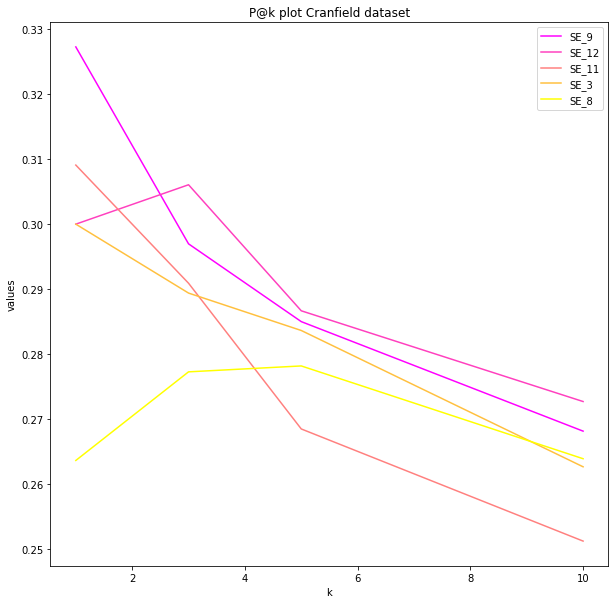

In [57]:
plot1 = p_at_k_df.plot(y=['SE_9','SE_12','SE_11','SE_3','SE_8'],colormap="spring",\
              xlabel="k", ylabel="values",figsize=(10,10), title = 'P@k plot Cranfield dataset').get_figure();
plot1.savefig('Cranfield_p_plot.jpg')

In [58]:
# normalized Discounted Cumulative Gain (nDCG)
def n_dcg(se,gt,k):
    rel=0
    dcg=0
    idcg=0
    ndcg=[]
    Q=set(gt['Query_id'].unique())
    for i in Q:
        seID = se['Doc_ID'].loc[se['Query_id'] == i].tolist()
        gtID = gt['Relevant_Doc_id'].loc[gt['Query_id'] == i].tolist()
        for el in gtID:
            for it in seID[:k]:
                rel=1 if it==el else 0
        for p in range(1,k+1):
            dcg+=rel/(math.log2(p+1))
            idcg+=1/(math.log2(p+1))
        ndcg.append(dcg/idcg)
    return (mean(ndcg))

In [59]:
#nDCG with top 5
def ndcg_topfive(top,k):
    ndcg_list =[]
    gt = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET\cran_Ground_Truth.tsv", sep='\t')
    for i in top:
        sr = pd.read_csv(os.getcwd()+"\part_1\part_1_1\Cranfield_DATASET"+ str(i)+".csv",sep=',')
        ndcg_list.append(n_dcg(sr,gt,k))
    return ndcg_list

k_list = [1, 3, 5, 10]
output_ndcg=[]
for k in k_list:
    output_ndcg.append(ndcg_topfive(top_five,k))
ndcg_df = pd.DataFrame(output_ndcg)
ndcg_df.index = k_list
ndcg_df.columns = ['SE_9','SE_12','SE_11','SE_3','SE_8'] #TOP 5 SE configuration

In [60]:
ndcg_df

,SE_9,SE_12,SE_11,SE_3,SE_8
1,0.033157,0.026385,0.033421,0.030050,0.006779
3,0.073917,0.088605,0.055917,0.082612,0.076389
5,0.067633,0.065332,0.059142,0.046318,0.066441
10,0.068141,0.050131,0.064272,0.047363,0.067835


### PLOT nDCG with top 5

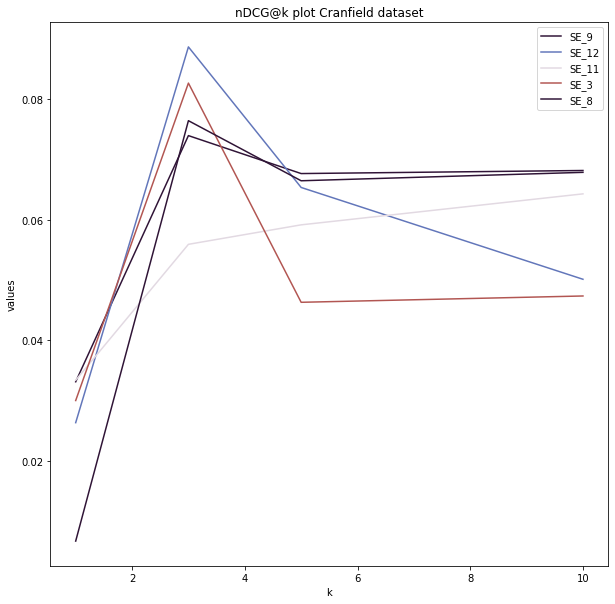

In [61]:
plot2 = ndcg_df.plot(y=['SE_9','SE_12','SE_11','SE_3','SE_8'],colormap="twilight_shifted",\
            xlabel="k", ylabel="values",figsize=(10,10), title = 'nDCG@k plot Cranfield dataset').get_figure();

#plot2.savefig('ndcg_plot.jpg')